# Field maps of the 3 differents spheres

In this first notebook, we analysed the data of acquired field maps (FM) of 5 different materials + one empty

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import nibabel as nib
import cv2
from sklearn.linear_model import LinearRegression 
import scipy
import scipy.io
from skimage.transform import rescale as resc
from skimage.transform import downscale_local_mean
import tikzplotlib
from matplotlib.gridspec import GridSpec

In [2]:
### parameters and constants
TE1=3.06*0.001 #s
TE2=4.08*0.001 #s
delta_TE=TE2-TE1
gamma = 2.675221900e8 # /s/T

## I. Just water and salt

In [3]:
def mask(path_mag1, material, tresh, plot=True, slice=71):
    '''
    Return a mask with 0 if inside the ball and 1 outside

    Parameters
    ----------
    path_mag1 : str
        path to the magnitude 1 of the material.
    material : str
        description of the material.
    tresh : float
        magnetude treshold of the mask.
    plot : bool, optional
        if true, plot a slice of the magnitude and of the mask. The default is True.
    slice : int, optional
        the slice to plot. The default is 71.

    Returns
    -------
    mask : numpy.ndarray
        mask of the ball.

    '''
    ######## magnitude #############
    mag1 = nib.load(path_mag1)
    data_mag1=mag1.get_fdata() #extract matrix with values
    
    mask = data_mag1 > tresh #return array of booleens
    
    #plot the selected slice 
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.imshow(data_mag1[:,:,slice])
        plt.colorbar()
        plt.title(f'Magnitude_1 of {material}')
    
        plt.subplot(1,2,2)
        plt.imshow(mask[:, :, slice])
        plt.colorbar()
        plt.title(f'Mask of {material}')
        
        plt.tight_layout()

    return mask

In [4]:
def rescale(path_mag1, path_mag2, path_phase, material, deltaTE, slice=70, masking=False):
    '''
    Rescale the acquired phase difference to a field map in Hz.
    
    Rescale from the phase difference in 2^13 bits to a field map in Hz, and plot the magnitude, phase difference and field map.
    If masking = True then put values inside the ball at zero.


    Parameters
    ----------
    path_mag1 : str
        path to the first magnitude.
    path_mag2 : str
        path to the second magnitude.
    path_phase : str
        path to the phase difference.
    material : str
        description opf the material.
    deltaTE : float
        TE2-TE1.
    slice : int, optional
        Slice to plot. The default is 70.
    masking : bool, optional
        apply the mask of the magnitude to the field map. The default is False.

    Returns
    -------
    data_phase : numpy.ndarray
        rescaled field map in Hz.

    '''
    ######## magnitude #############
    mag1 = nib.load(path_mag1)
    data_mag1=mag1.get_fdata() #extract matrix with values
    mag2 = nib.load(path_mag2)
    data_mag2=mag2.get_fdata() #extract matrix with values
    
    #plot the selected slice 
    plt.figure('f{material}', figsize=(15,15))
    
    plt.subplot(2,2,1)
    plt.imshow(data_mag1[:,:,slice])
    plt.colorbar()
    plt.title(f'Magnitude_1 of {material}')
    
    plt.subplot(2,2,2)
    plt.imshow(data_mag2[:,:,slice])
    plt.colorbar()
    plt.title(f'Magnitude_2 of {material}')
    
    ########### phase difference and field map ############
    fm_unscaled = nib.load(path_phase)
    data_phase=fm_unscaled.get_fdata() #extract matrix with values
    
    #plot phase difference
    plt.subplot(2,2,3)
    plt.imshow(data_phase[:,:,slice])
    plt.colorbar()
    plt.title(f'Phase difference of {material}')
    
    #rescaling:
    data_phase *= np.pi/4096 #set the phase between -pi and pi
    data_phase /= (deltaTE*2*np.pi) #in Hz
    #data_phase /= gamma # in T
    
    # apply the mask if needed
    if masking==True:
        maske=mask(path_mag1, material, 400, plot=False, slice=slice)
        data_phase *= maske
    
    
    
    #plot the selected slice of field map
    plt.subplot(2,2,4)
    plt.imshow(data_phase[:,:,slice])
    plt.colorbar()
    plt.title(f'Field map (Hz) of {material}')
    plt.show()

    return data_phase 

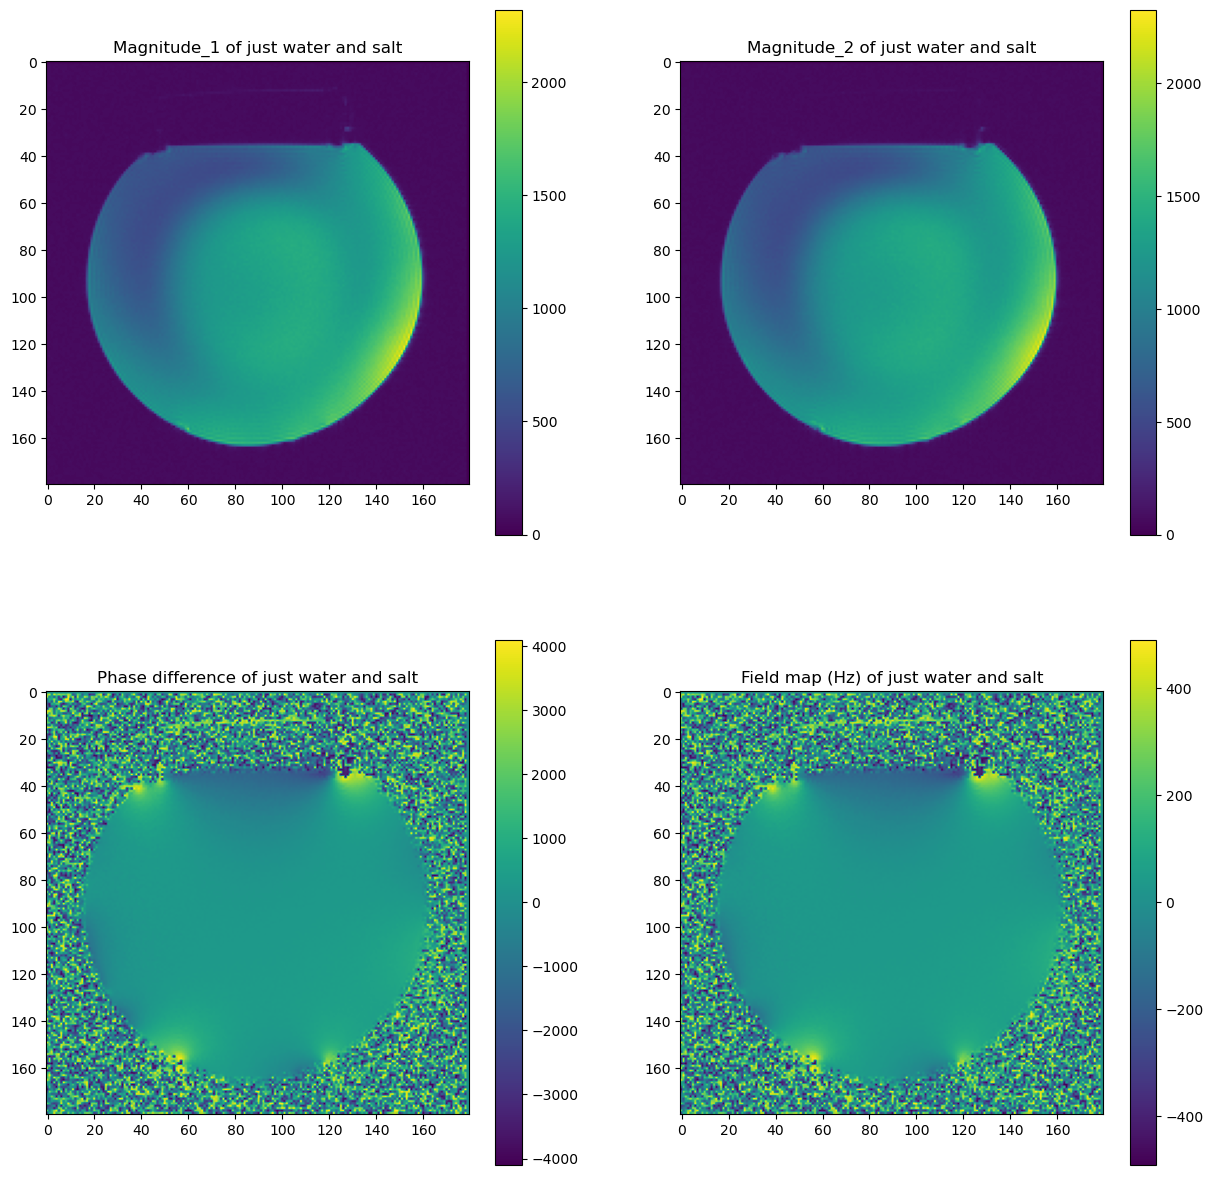

In [5]:
path_mag1_none = "FM_1_0MM_NONE_0002\FM_1_0MM_NONE_0002\FM_1_0MM_NONE_0002_fm_1.0mm_none_20220929134832_2_e1.nii"
path_mag2_none = "FM_1_0MM_NONE_0002\FM_1_0MM_NONE_0002\FM_1_0MM_NONE_0002_fm_1.0mm_none_20220929134832_2_e2.nii"
path_phase_none = "FM_1_0MM_NONE_0003\FM_1_0MM_NONE_0003\FM_1_0MM_NONE_0003_fm_1.0mm_none_20220929134832_3_e2_ph.nii"
delta_B_none = rescale(path_mag1_none,path_mag2_none ,path_phase_none, "just water and salt", delta_TE)

## II. FDM_PLA

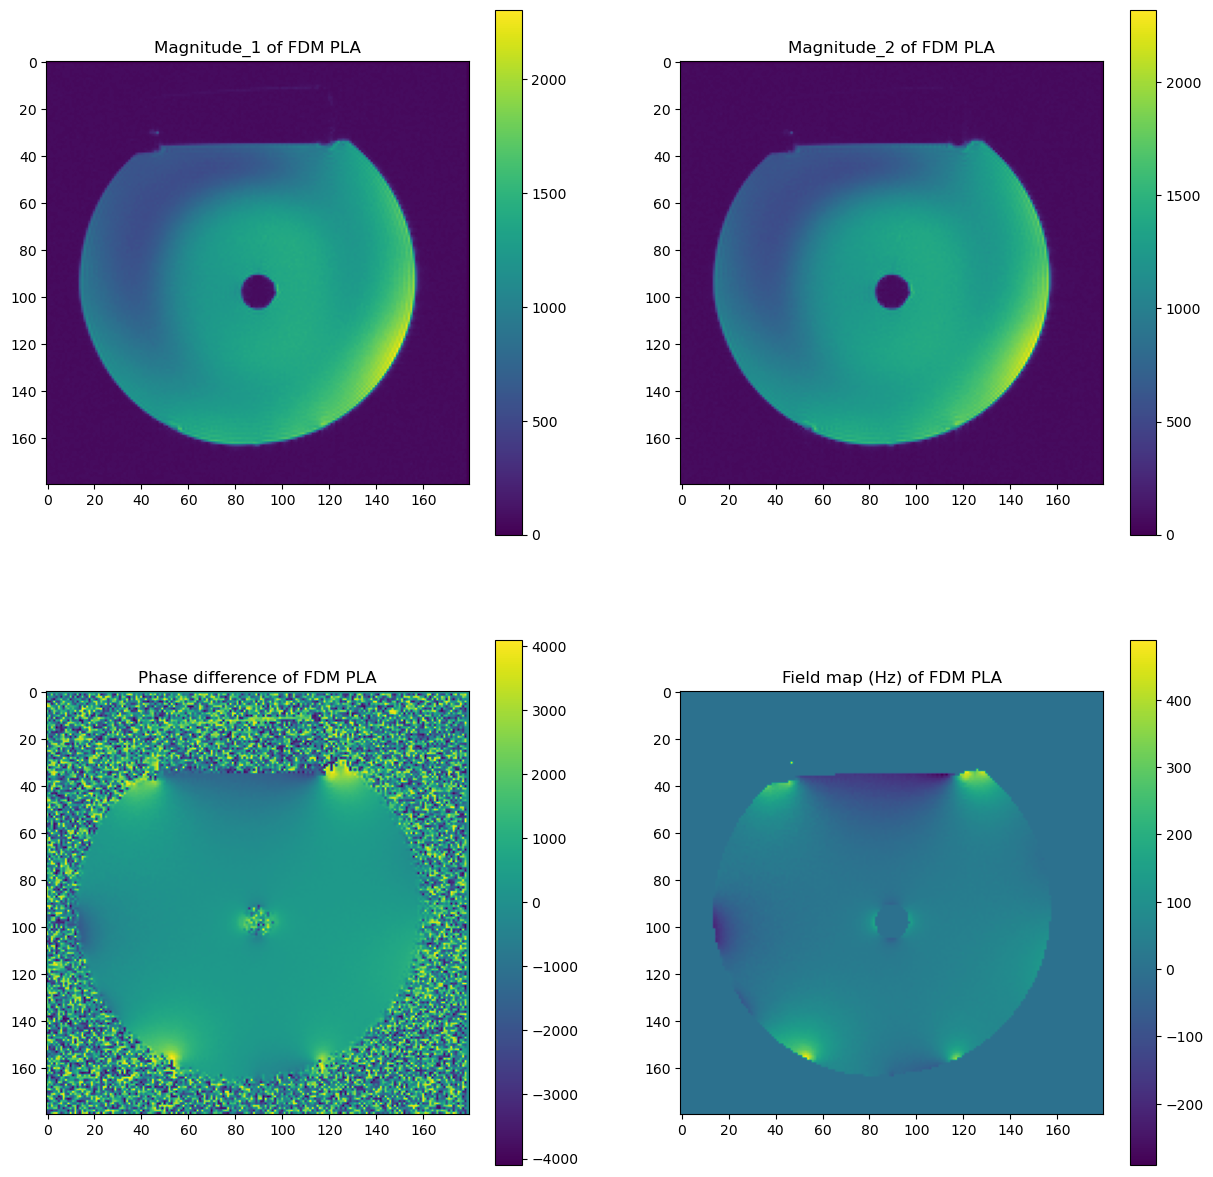

In [6]:
path_mag1_pla = "FM_1_0MM_FDM_PLA_0010\FM_1_0MM_FDM_PLA_0010\FM_1_0MM_FDM_PLA_0010_fm_1.0mm_FDM_PLA_20220929134832_10_e1.nii"
path_mag2_pla = "FM_1_0MM_FDM_PLA_0010\FM_1_0MM_FDM_PLA_0010\FM_1_0MM_FDM_PLA_0010_fm_1.0mm_FDM_PLA_20220929134832_10_e2.nii"
path_phase_pla = "FM_1_0MM_FDM_PLA_0011\FM_1_0MM_FDM_PLA_0011\FM_1_0MM_FDM_PLA_0011_fm_1.0mm_FDM_PLA_20220929134832_11_e2_ph.nii"
delta_B_PLA = rescale(path_mag1_pla, path_mag2_pla, path_phase_pla, "FDM PLA", delta_TE, masking=True)


## III. SLA STD white

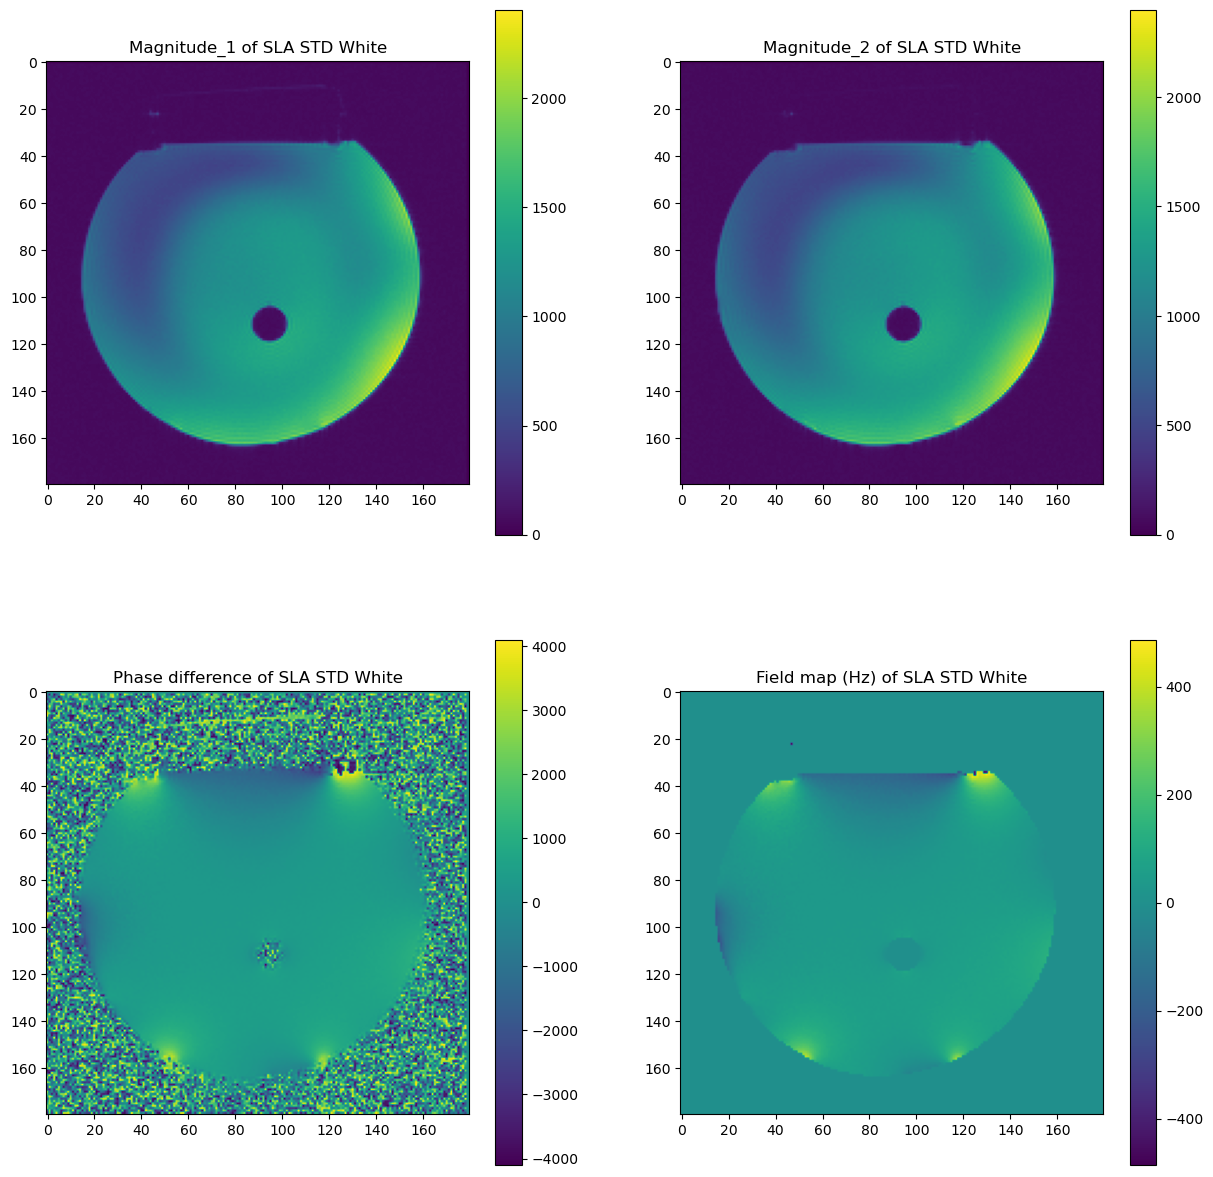

In [7]:
path_mag1_sla = "FM_1_0MM_SLA_STD_WHITE_0006\FM_1_0MM_SLA_STD_WHITE_0006\FM_1_0MM_SLA_STD_WHITE_0006_fm_1.0mm_SLA_STD_white_20220929134832_6_e1.nii"
path_mag2_sla = "FM_1_0MM_SLA_STD_WHITE_0006\FM_1_0MM_SLA_STD_WHITE_0006\FM_1_0MM_SLA_STD_WHITE_0006_fm_1.0mm_SLA_STD_white_20220929134832_6_e2.nii"
path_phase_sla = "FM_1_0MM_SLA_STD_WHITE_0007\FM_1_0MM_SLA_STD_WHITE_0007\FM_1_0MM_SLA_STD_WHITE_0007_fm_1.0mm_SLA_STD_white_20220929134832_7_e2_ph.nii"
delta_B_sla = rescale(path_mag1_sla, path_mag2_sla, path_phase_sla, "SLA STD White", delta_TE, 84, masking=True)

## IV. MSP_3MCrystal

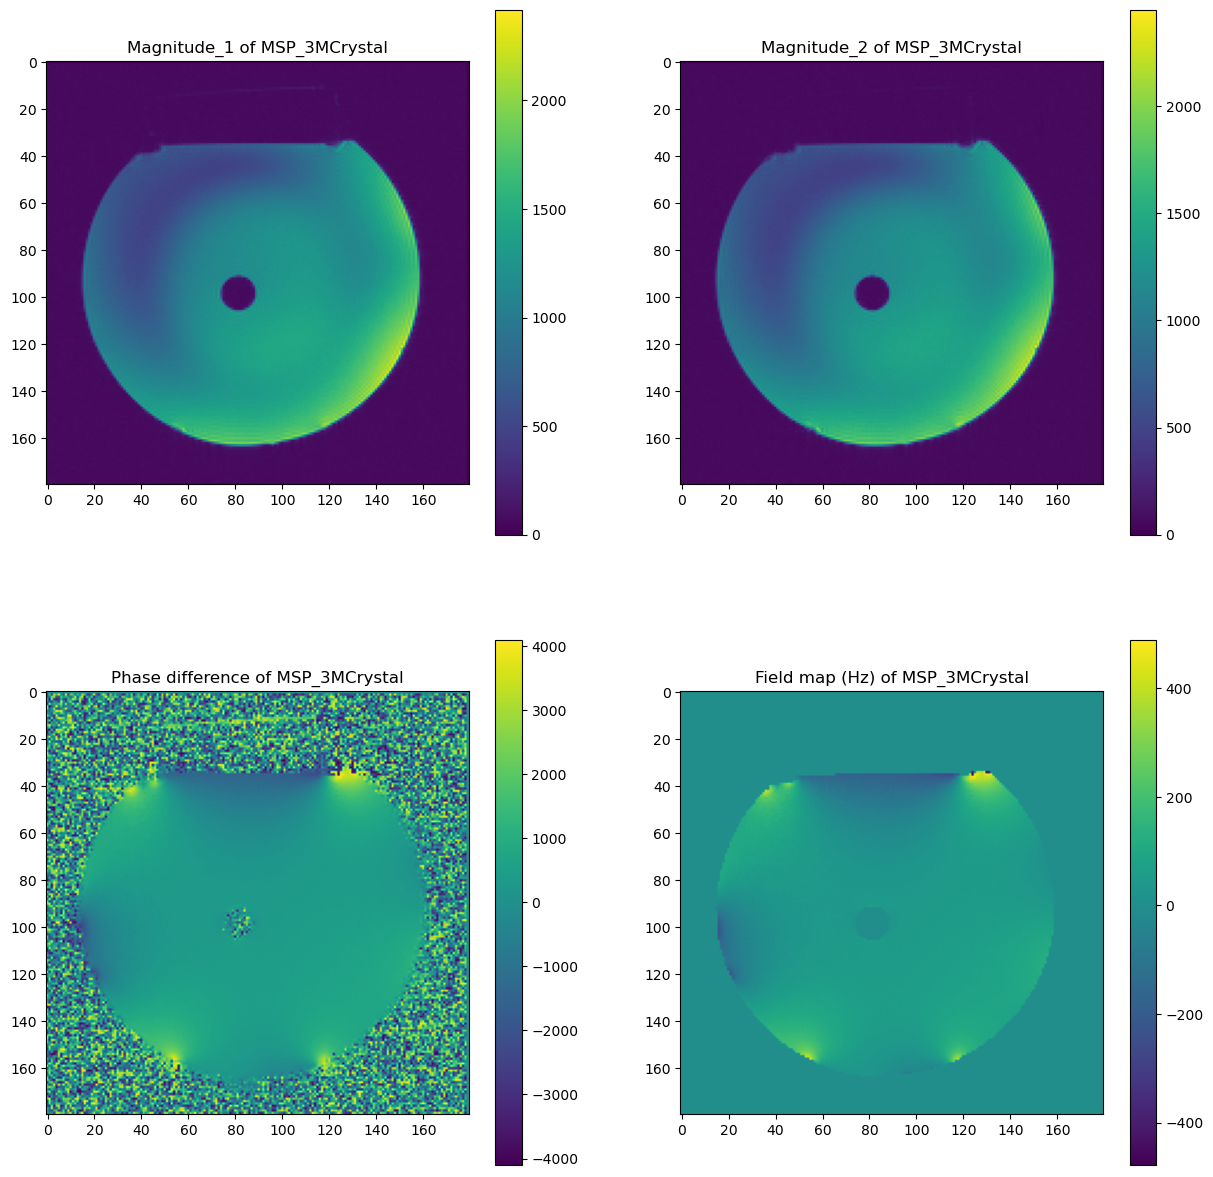

In [8]:
path_mag1_crystal = "FM_1_0MM_MSP_3MCRYSTAL_0014\FM_1_0MM_MSP_3MCRYSTAL_0014\FM_1_0MM_MSP_3MCRYSTAL_0014_fm_1.0mm_MSP_3MCrystal_20220929134832_14_e1.nii"
path_mag2_crystal = "FM_1_0MM_MSP_3MCRYSTAL_0014\FM_1_0MM_MSP_3MCRYSTAL_0014\FM_1_0MM_MSP_3MCRYSTAL_0014_fm_1.0mm_MSP_3MCrystal_20220929134832_14_e2.nii"
path_phase_crystal = "FM_1_0MM_MSP_3MCRYSTAL_0015\FM_1_0MM_MSP_3MCRYSTAL_0015\FM_1_0MM_MSP_3MCRYSTAL_0015_fm_1.0mm_MSP_3MCrystal_20220929134832_15_e2_ph.nii"
delta_B_crystal = rescale(path_mag1_crystal, path_mag2_crystal, path_phase_crystal, "MSP_3MCrystal", delta_TE, 87, masking=True)

## V. Flexible material

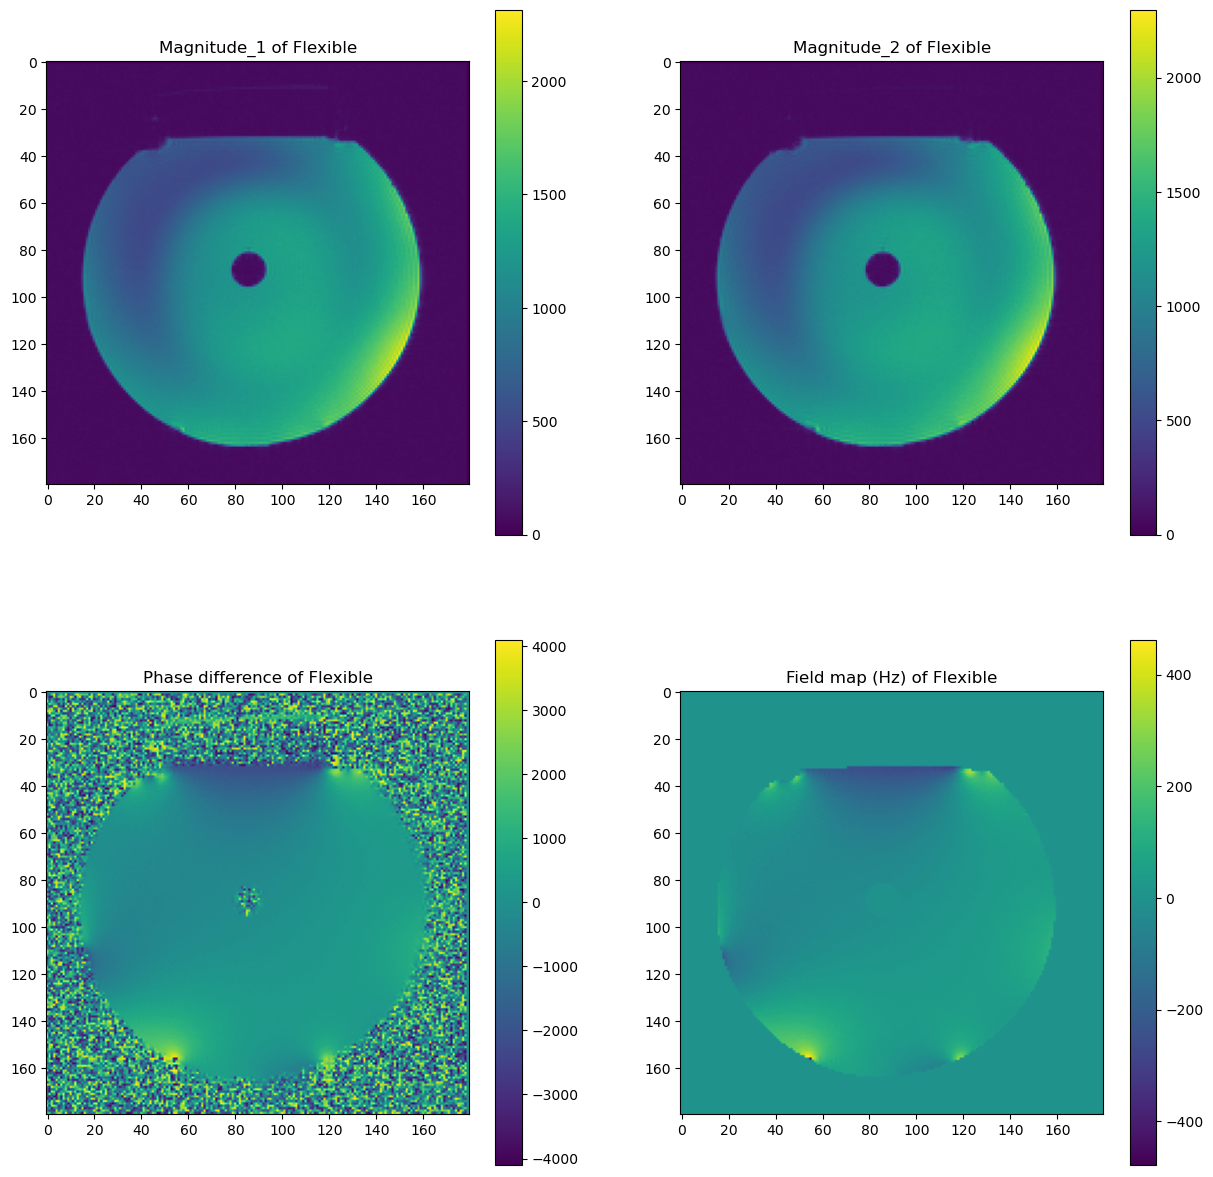

In [9]:
path_mag1_flexible = r"..\221013_test2_C345\BILLI_PHANTOM_22_10_13\johanna_billy\FM_1_0MM_flexible_0011\FM_1_0~3_fm_1.0mm_MSP_3MCrystal_20221013165548_11_e1.nii"
path_mag2_flexible = r"..\221013_test2_C345\BILLI_PHANTOM_22_10_13\johanna_billy\FM_1_0MM_flexible_0011\FM_1_0~3_fm_1.0mm_MSP_3MCrystal_20221013165548_11_e2.nii"
path_phase_flexible = r"..\221013_test2_C345\BILLI_PHANTOM_22_10_13\johanna_billy\FM_1_0MM_flexible_0012\FM_1_0~4_fm_1.0mm_MSP_3MCrystal_20221013165548_12_e2_ph.nii"
delta_B_flexible = rescale(path_mag1_flexible, path_mag2_flexible, path_phase_flexible, "Flexible", delta_TE, 73, masking=True)

## VI. Nylon

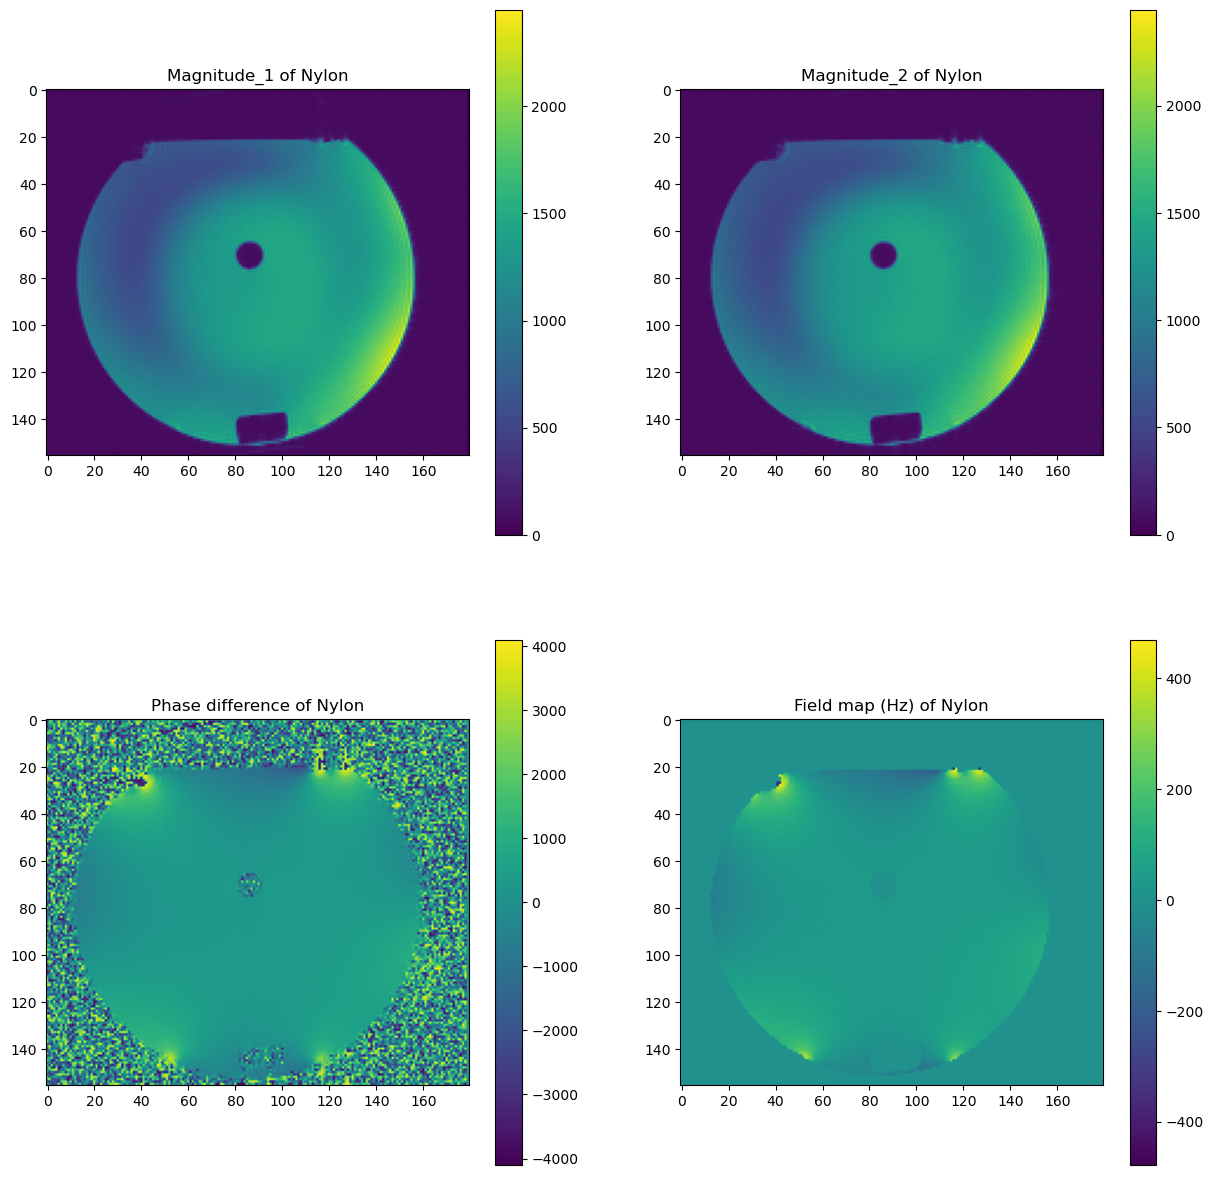

In [10]:
path_mag1_nylon = r"..\230327_test7_nylon_less_sugar\FM_1_0MM_NYLON_WATERSOAPSALT_0002\FM_1_0MM_NYLON_WATERSOAPSALT_0002_fm_1.0mm_nylon_waterSoapSalt_20230327150132_2_e1.nii.gz"
path_mag2_nylon = r"..\230327_test7_nylon_less_sugar\FM_1_0MM_NYLON_WATERSOAPSALT_0002\FM_1_0MM_NYLON_WATERSOAPSALT_0002_fm_1.0mm_nylon_waterSoapSalt_20230327150132_2_e2.nii.gz"
path_phase_nylon = r"..\230327_test7_nylon_less_sugar\FM_1_0MM_NYLON_WATERSOAPSALT_0003\FM_1_0MM_NYLON_WATERSOAPSALT_0003_fm_1.0mm_nylon_waterSoapSalt_20230327150132_3_e2_ph.nii.gz"
delta_B_nylon = rescale(path_mag1_nylon, path_mag2_nylon, path_phase_nylon, "Nylon", delta_TE, 73, masking=True)

In the two next coding boxes, we try to find and define x_nylon, y_nylon, z_nylon the center of the nylon ball

In [11]:
##############################################################################""""""
x_nylon, y_nylon, z_nylon = 85,69,77 #center of the ball
dx, dy, dz = 12,12,12 # 0.5 * width of the field map we will have after resphaping the 3D array to a smaller one around the ball
#################################################################################


(156, 180, 160)


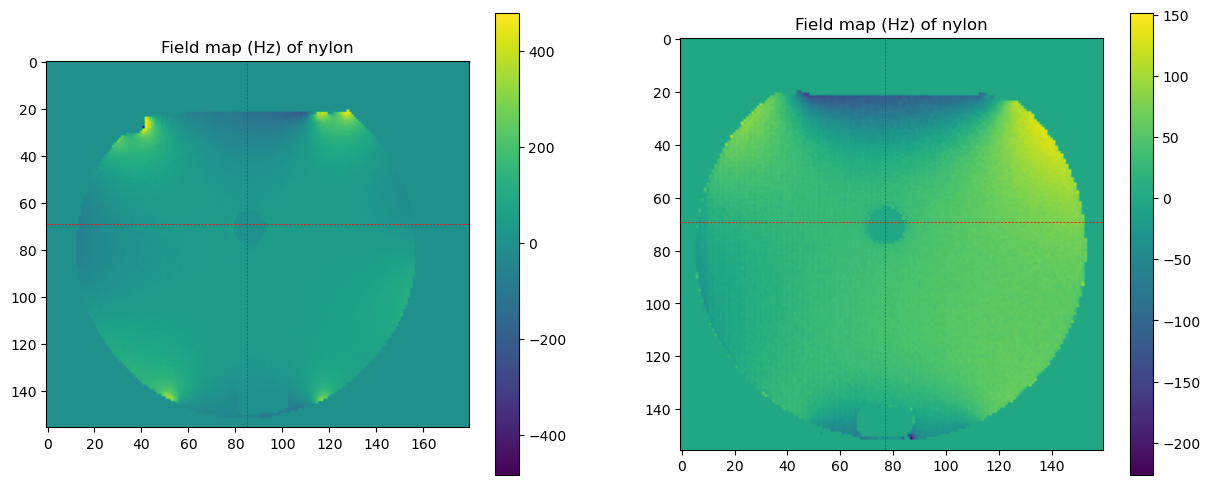

In [12]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(delta_B_nylon[:,:,z_nylon])
plt.colorbar()
plt.axvline(x=x_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=y_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.title(f'Field map (Hz) of nylon')

plt.subplot(1,2,2)
plt.imshow(delta_B_nylon[:,x_nylon,:])
plt.colorbar()
plt.axvline(x=z_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=y_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.title(f'Field map (Hz) of nylon')

print(np.shape(delta_B_nylon))

## VII. Visual comparison of the 5 field maps of the materials


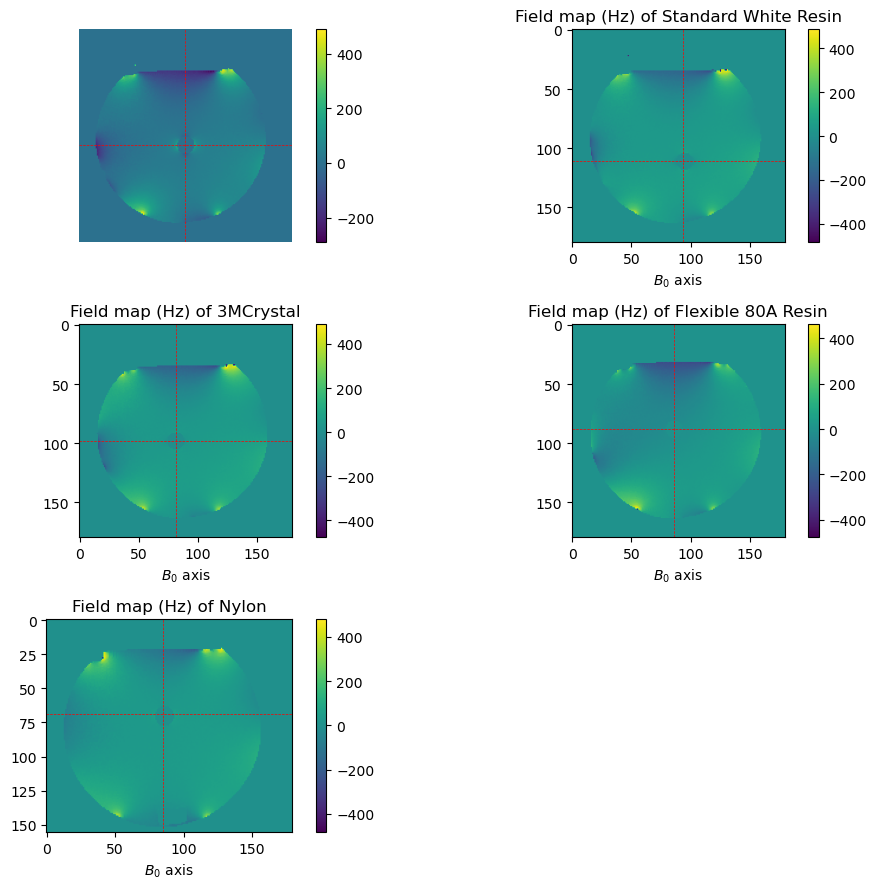

In [13]:
plt.figure(figsize=(10,9))
# plt.figure(figsize=(10,8))

plt.subplot(3,2,1)
plt.imshow(delta_B_PLA[:,:,70])
plt.colorbar()
plt.axvline(x=89,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=97,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
# plt.title(f'Field map (Hz) of PLA')
plt.xlabel('$B_0$ axis')
plt.axis('off')

plt.subplot(3,2,2)
plt.imshow(delta_B_sla[:,:,84])
plt.axvline(x=94,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=111,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of Standard White Resin')

plt.xlabel('$B_0$ axis')

plt.subplot(3,2,3)
plt.imshow(delta_B_crystal[:,:,87])
plt.axvline(x=81,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=98,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of 3MCrystal')
plt.xlabel('$B_0$ axis')

plt.subplot(3,2,4)
plt.imshow(delta_B_flexible[:,:,73])
plt.axvline(x=86,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=88,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of Flexible 80A Resin')
plt.xlabel('$B_0$ axis')

plt.subplot(3,2,5)
plt.imshow(delta_B_nylon[:,:,z_nylon])
plt.axvline(x=x_nylon,color='r',linestyle='--', linewidth=0.5)
plt.axhline(y=y_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.colorbar()
plt.title(f'Field map (Hz) of Nylon')

# tikzplotlib.save(r"figures\field_maps_pla.pgf")
plt.xlabel('$B_0$ axis')
plt.tight_layout()

plt.show()

## VII. Line plots in the x, y and z directions

In [14]:
########### Coordinates center of the balls
x_pla, y_pla, slice_pla = 89, 97, 70
x_sla, y_sla, slice_sla = 94, 111, 84
x_crystal, y_crystal, slice_crystal = 81,98, 87
x_flexible, y_flexible, slice_flexible = 86, 88, 73
x_nylon, y_nylon, z_nylon = 85,69,77

###########

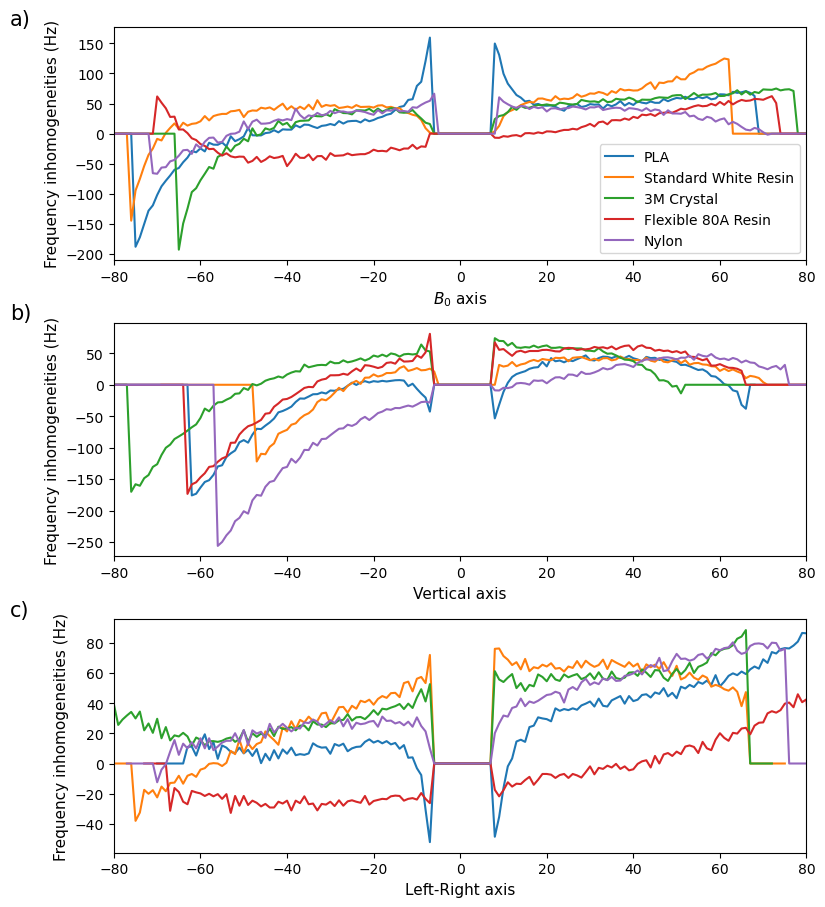

In [15]:
##### plot lineplot axe horizontal
freq_pla_x = (delta_B_PLA[y_pla, :, slice_pla])
freq_sla_x = (delta_B_sla[y_sla, :, slice_sla])
freq_crystal_x = (delta_B_crystal[y_crystal, :, slice_crystal])
freq_flexible_x = (delta_B_flexible[y_flexible, :, slice_flexible])
freq_nylon_x = (delta_B_nylon[y_nylon, :, z_nylon])

abscisse_nylon_x = [i-x_nylon for i in range(180)] #recenter the ball at zero
abscisse_pla_x = [i-x_pla for i in range(180)] #recenter the ball at zero
abscisse_sla_x = [i-x_sla for i in range(180)]
abscisse_crystal_x = [i-x_crystal for i in range(180)]
abscisse_flexible_x = [i-x_flexible for i in range(np.shape(delta_B_flexible)[1])]


plt.figure(figsize=(8,9))
plt.subplot(3,1,1)
plt.plot(abscisse_pla_x, freq_pla_x, label='PLA')
plt.plot(abscisse_sla_x, freq_sla_x, label='Standard White Resin')
plt.plot(abscisse_crystal_x, freq_crystal_x, label='3M Crystal')
plt.plot(abscisse_flexible_x, freq_flexible_x, label='Flexible 80A Resin')
plt.plot(abscisse_nylon_x, freq_nylon_x, label='Nylon')


# plt.title('Comparaison inhomogeneities of frequences along the horizontal axis ($B_0$ axis)')
plt.xlabel('$B_0$ axis', size=11)
plt.ylabel('Frequency inhomogeneities (Hz)', size=11)
plt.xlim(-80,80)
plt.legend()


##### plot lineplot axe vertical
freq_pla_y = (delta_B_PLA[:,x_pla, slice_pla])
freq_sla_y = (delta_B_sla[:, x_sla, slice_sla])
freq_crystal_y = (delta_B_crystal[:, x_crystal, slice_crystal])
freq_flexible_y = (delta_B_flexible[:, x_flexible, slice_flexible])
# freq_iodine_y = (delta_B_iodine[:, x_iodine, slice_iodine])
# freq_iron_y = (delta_B_iron[:, x_iron, slice_iron])

freq_nylon_y = (delta_B_nylon[:, x_nylon, z_nylon])

abscisse_nylon_y = [i-y_nylon for i in range(np.shape(delta_B_nylon)[0])] #recenter the ball at zero


abscisse_pla_y = [i-y_pla for i in range(180)] #recenter the ball at zero
abscisse_sla_y = [i-y_sla for i in range(180)]
abscisse_crystal_y = [i-y_crystal for i in range(180)]
abscisse_flexible_y = [i-y_flexible for i in range(np.shape(delta_B_flexible)[0])]
# abscisse_iodine_y = [i-y_iodine for i in range(np.shape(delta_B_iodine)[0])]
# abscisse_iron_y = [i-y_iron for i in range(np.shape(delta_B_iron)[0])]


plt.subplot(3,1,2)
plt.plot(abscisse_pla_y, freq_pla_y, label='PLA')
plt.plot(abscisse_nylon_y, freq_nylon_y, label='Nylon')
plt.plot(abscisse_sla_y, freq_sla_y, label='Standard White Resin')
plt.plot(abscisse_crystal_y, freq_crystal_y, label='3M Crystal')
plt.plot(abscisse_flexible_y, freq_flexible_y, label='Flexible 80A Resin')
# plt.title('Comparaison inhomogeneities of frequences along the vertical axis')
plt.xlabel('Vertical axis', size=11)
plt.ylabel('Frequency inhomogeneities (Hz)', size=11)
plt.xlim(-80,80)
# plt.legend()


##### plot lineplot axe profondeur
freq_pla_z = (delta_B_PLA[y_pla,x_pla, :])
freq_sla_z = (delta_B_sla[y_sla, x_sla, :])
freq_crystal_z = (delta_B_crystal[y_crystal, x_crystal, :])
freq_flexible_z = (delta_B_flexible[y_flexible, x_flexible, :])
freq_nylon_z = (delta_B_nylon[y_nylon, x_nylon, :])

abscisse_nylon_z = [i-z_nylon for i in range(np.shape(delta_B_nylon)[2])] #recenter the ball at zer
abscisse_pla_z = [i-slice_pla for i in range(160)] #recenter the ball at zero
abscisse_sla_z = [i-slice_sla for i in range(160)]
abscisse_crystal_z = [i-slice_crystal for i in range(160)]
abscisse_flexible_z = [i-slice_flexible for i in range(np.shape(delta_B_flexible)[2])]

plt.subplot(3,1,3)
plt.plot(abscisse_pla_z, freq_pla_z, label='PLA')
plt.plot(abscisse_sla_z, freq_sla_z, label='Standard White Resin')
plt.plot(abscisse_crystal_z, freq_crystal_z, label='3M Crystal')
plt.plot(abscisse_flexible_z, freq_flexible_z, label='Flexible 80A Resin')

plt.plot(abscisse_nylon_z, freq_nylon_z, label='Nylon')
# plt.title('Comparaison inhomogeneities of frequences along the slices axis')
plt.xlabel('Left-Right axis', size=11)
plt.ylabel('Frequency inhomogeneities (Hz)', size=11)
plt.xlim(-80,80)

# plt.legend()
# tikzplotlib.save(r"figures\lineplots_5materials.tex")

plt.tight_layout()

plt.text(x= -104 ,y=490, s='a)', size=15)
plt.text(x= -104 ,y=295, s='b)', size=15)
plt.text(x= -104 ,y=98, s='c)', size=15)
# plt.savefig(r"C:\Users\b\OneDrive\Documents\NTNU\Master's thesis\tests materiaux\220929_test1_materiaux\figures\lineplots_5materials.png", transparent=False)

plt.show()


# Definition of the masks

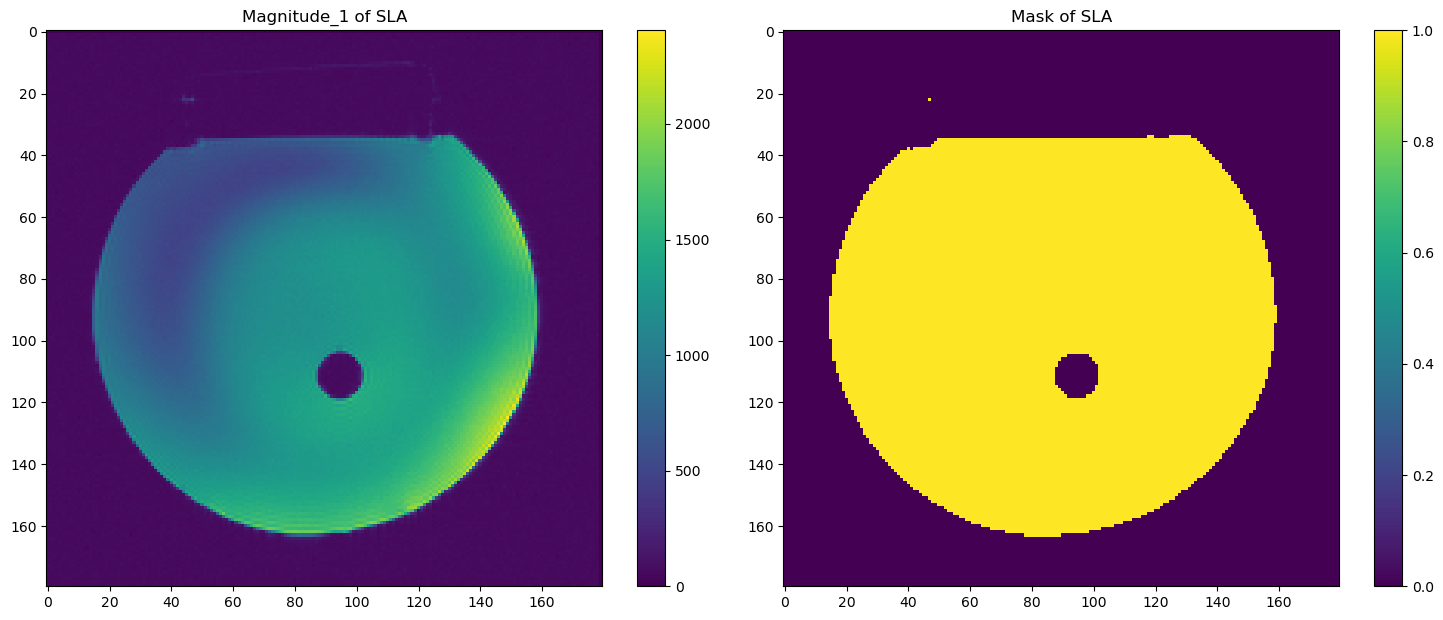

In [16]:
mask_sla = mask(path_mag1_sla,"SLA", 400, slice=84)

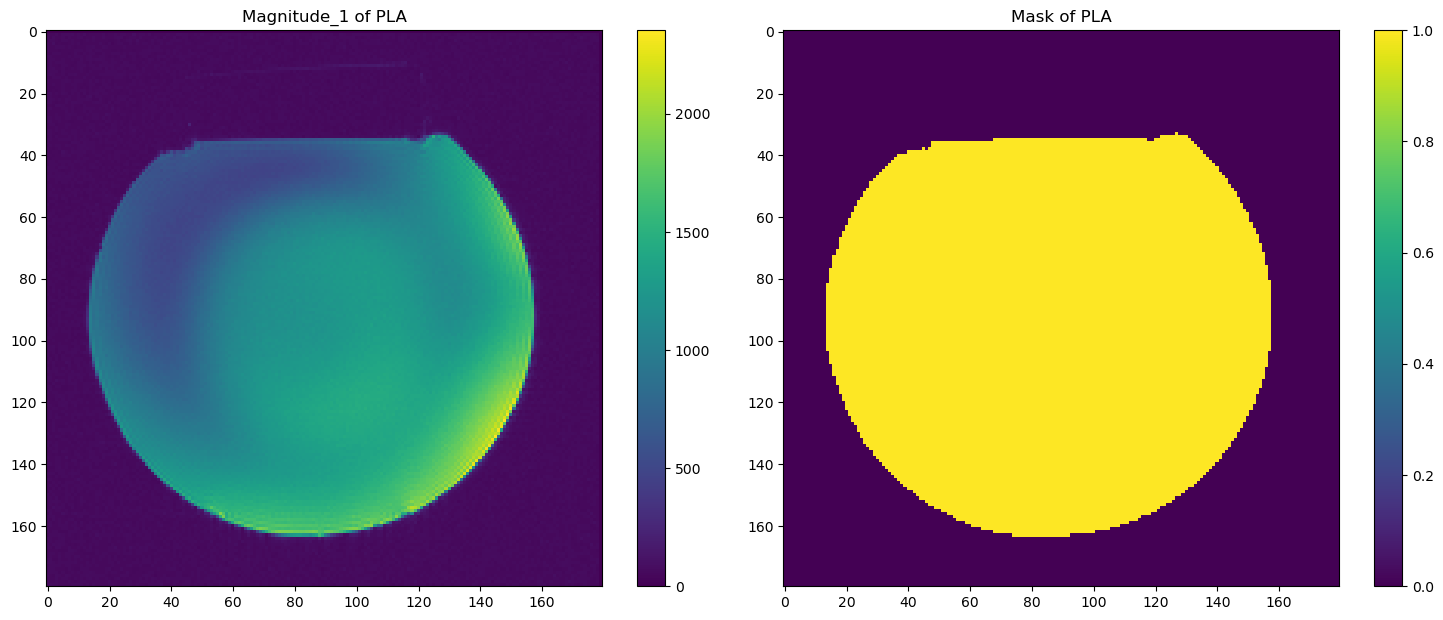

In [17]:
mask_pla = mask(path_mag1_pla,"PLA", 400, slice=84)


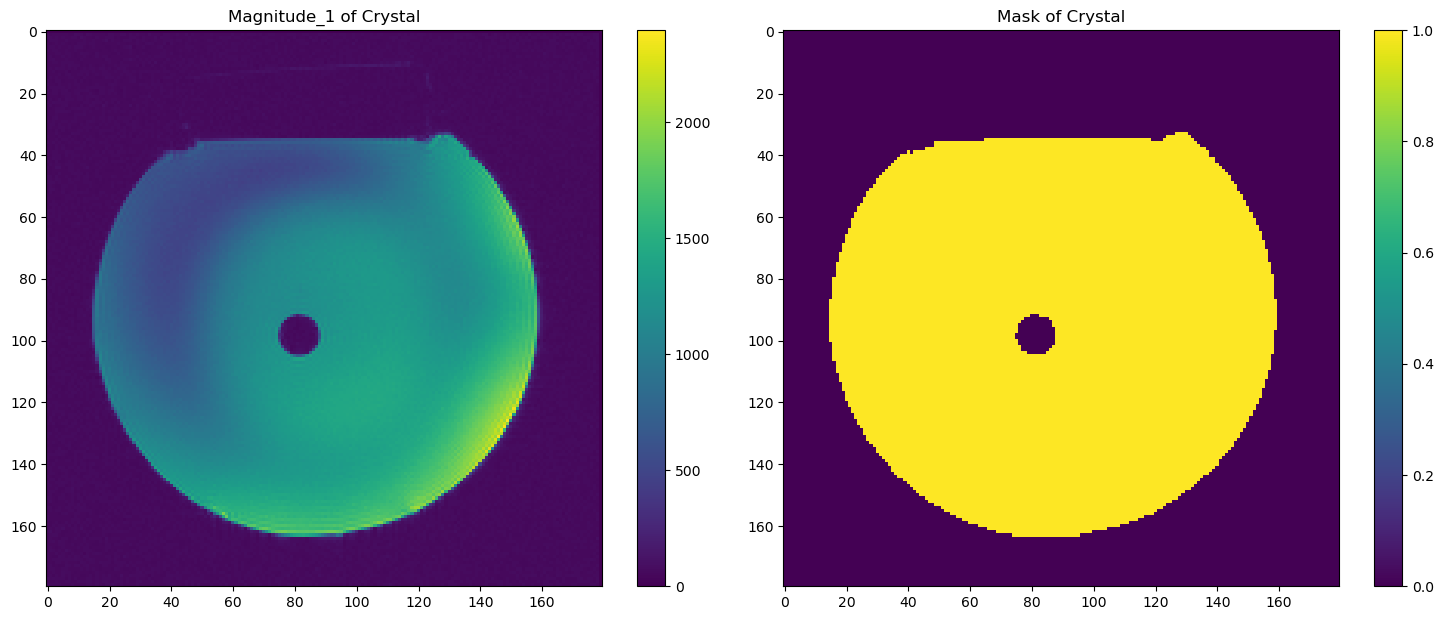

In [18]:
mask_crystal = mask(path_mag1_crystal,"Crystal", 400, slice=84)


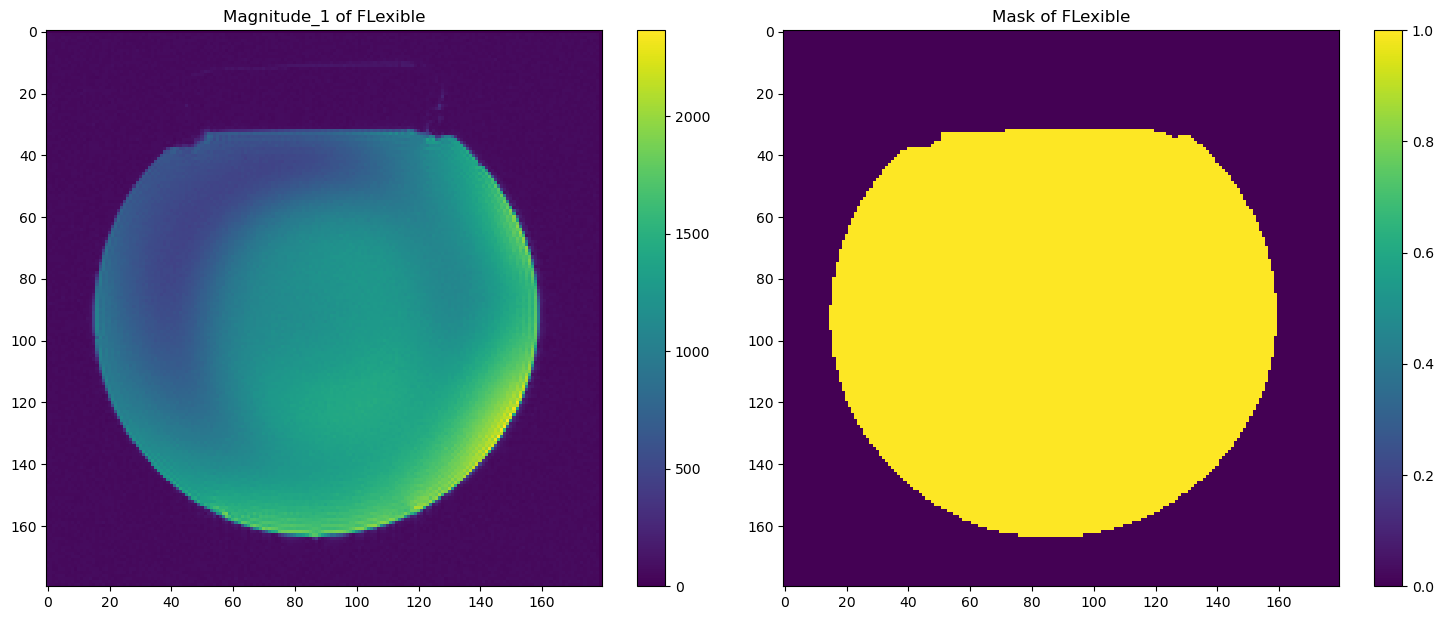

In [19]:
mask_flexible = mask(path_mag1_flexible,"FLexible", 400, slice=84)


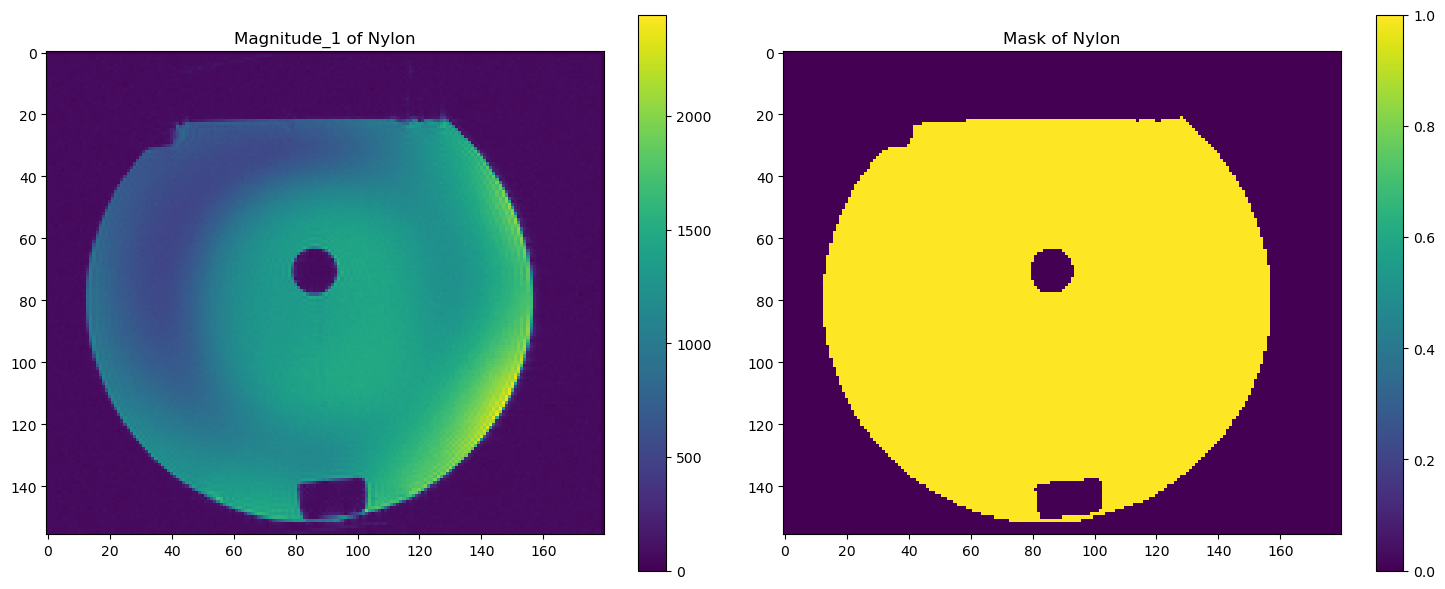

In [20]:
mask_nylon = mask(path_mag1_nylon,"Nylon", 400, slice=z_nylon)


# Comparison of the field map with the simulated field map

### I. Rescaling the field map to zero 

First, we need to rescale the environment of water/salt around the material to 0, so we can compare with the simulation. 
To do this, we compute the mean value of the water background in the center of the image

#### A. Creating a round mask in the center of the water + salt and calculating the average

In [21]:
############## define the center of the image ##############
x_center = 180/2-0.5
y_center = 180/2-0.5
z_center = 160/2-0.5
############################################################

In [22]:
def mask_round(field_map, x=x_center,y=y_center,z=z_center, slice=71, diameter = 50, plot=True):
    '''
    Define a spherical mask and compute the mean value of field_map inside that mask.
    
    The slice=slice of field_map is plotted if plot=true 
    A spherical mask of center x, y,z and diameter=diameter is defined and the same slice is plotted if plot=true.
    The mean value of the voxels of field_map inide the mask is computed. 
    Attention: x is the second component and y the first one.

    Parameters
    ----------
    field_map : numpy.ndarray
        array we want to compute the mean value.
    x : int, optional
        x coordinate of the center. The default is x_center.
    y : int, optional
        y coordinate of the center. The default is y_center.
    z : int, optional
        z coordinate of the center. The default is z_center.
    slice : int, optional
        slice to plot. The default is 71.
    diameter : int, optional
        diameter of the spherical mask. The default is 50.
    plot : bool, optional
        if true, field_map and mask_sphere are plotted. The default is True.

    Returns
    -------
    mask_sphere : numpy.ndarray
        spherical mask.
    avg_background : float
        average background value of field_map inside the mask.

    '''
    m,n,p=(np.shape(field_map))
    mask_sphere = np.zeros((m,n,p))
    c=0
    avg_background=0

    for i in range(int(y- diameter/2)-1, int( y+diameter/2)+1):
        for j in range( int(x-diameter/2)-1, int(x+ diameter/2)+1):
            for k in range( int(z-diameter/2)-1, int(z+diameter/2)+1):
                if (np.sqrt((y-i)**2+(x-j)**2+(z-k)**2) <= diameter/2 ) and (-1<i<m) and (-1<j<n) and (-1<k<p):
                    mask_sphere[i,j,k]=field_map[i,j,k]  
                    avg_background += field_map[i,j,k] #if we are in the sphere of interest, we add the value
                    c=c+1 #count how many values we added
    avg_background /=c
    
    if plot==True : 
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(field_map[:,:,slice])
        plt.colorbar()
        plt.title(f'FIeld map')
        
        plt.subplot(1,2,2)
        plt.imshow(mask_sphere[:,:,slice])
        plt.colorbar()
        plt.title(f'with mask')
        plt.tight_layout()
    return (mask_sphere, avg_background)


The average value of water+salt inhomogeneities in the center of a sphere of diameter=50 is 34.224742261167414 Hz


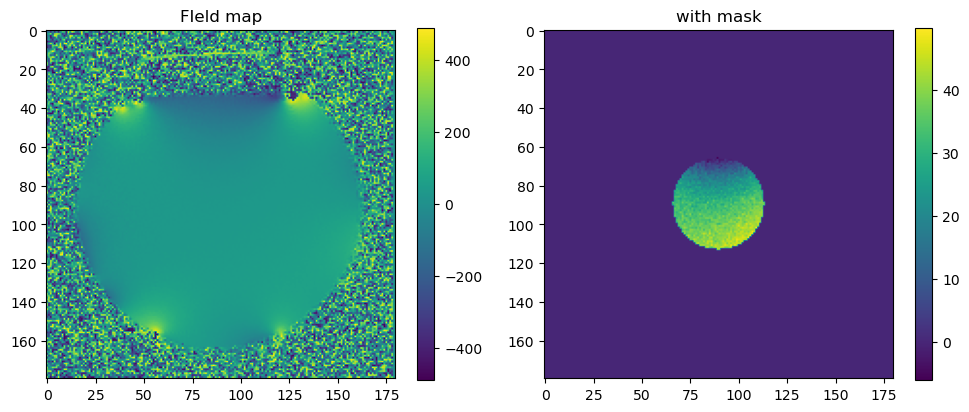

In [23]:
mask_none_rond, avg_water_background= mask_round(delta_B_none)
print(f'The average value of water+salt inhomogeneities in the center of a sphere of diameter=50 is {mask_round(delta_B_none, plot=False)[1]} Hz')

#### B. Rescaling the SLA's FM to a smaller FM centered on the ball, and rescaling the background value to zero

In [24]:
def rescaling_og_averaging(field_map, x=x_sla,y=y_sla,z=slice_sla, avg_back = avg_water_background, slice=25, diameter = 50, plot=True, mask=mask_sla, material = 'SLA'):
    '''
    Reshape field_map to a smaller array, and remove the water background

    Create a new smaller matrix of volume diameter*diameter*diamter with values recentered on x,y,z
    Remove the background value avg_back
    Attention: x is the second component and y the first one.

    Parameters
    ----------
    field_map : numpy.ndarray
        FM to reshape.
    x : int, optional
        x coordinate around which field_map will be reshaped. The default is x_sla.
    y : int, optional
        y coordinate around which field_map will be reshaped. The default is y_sla.
    z : int, optional
        z coordinate around which field_map will be reshaped. The default is slice_sla.
    avg_back : float, optional
        average value to remove. The default is avg_water_background.
    slice : int, optional
        slice to plot. The default is 25.
    diameter : int, optional
        width of the reshaped array. The default is 50.
    plot : bool, optional
        if plot= True, plot the reshaped array. The default is True.
    mask : numpy.ndarray, optional
        mask of 1 and 0, multiplied to the rescaled array after the background is removed. The default is mask_sla.
    material : str, optional
        description of the material. The default is 'SLA'.

    Returns
    -------
    rescaled_matrix : numpy.ndarray
        Reshaped array with background removed.

    '''
    m,n,p=(np.shape(field_map))
    fm_avgere = (field_map - avg_back) * mask #apply the averaging except if it is in the ball because it was already put at zero
    rescaled_matrix= fm_avgere[int(y-diameter/2)+1: int(y-diameter/2+1)+diameter, int(x-diameter/2+1): int(x-diameter/2+1)+diameter, int(z-diameter/2+1): int(z-diameter/2+1)+diameter] 

                
    if plot==True : 
        plt.figure()
        plt.imshow(rescaled_matrix[:,:,slice])
        plt.colorbar()
        plt.title(f'Field map rescaled of {material}')
        plt.axvline(x=diameter/2-0.5,color='r',linestyle='--', linewidth=0.5)
        plt.axhline(y=diameter/2-0.5,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball

   
    return rescaled_matrix


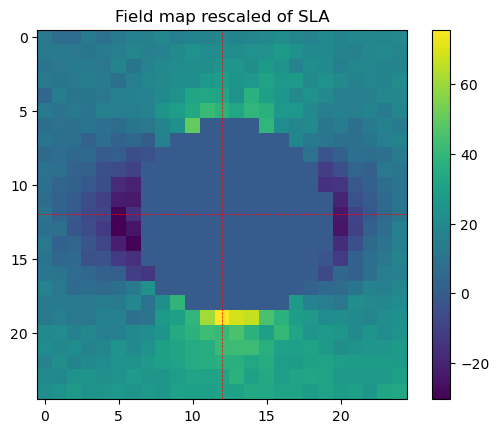

In [25]:
rescaled_sla_fm = rescaling_og_averaging(delta_B_sla, diameter=25, slice=15)

In [26]:
## The B0 axis is the horizontal axis ( ----> )
### We need to rotate the ball to have the B0 axis in the normal axis 
### 90° clock

def rotation90clock(A):
    """
    Rotate a 3D array 90 degrees clockwise around the B0 axis. 
    
    Parameters:
    -----------
    A : numpy.ndarray
        A 3D array of shape (m, n, p).
        
    Returns:
    --------
    A_new : numpy.ndarray
        A 3D array of shape (m, p, n) obtained by rotating A 90 degrees clockwise.
        
    """
    m,n,p = np.shape(A)
    A_new=np.zeros((m,p,n))
    for i in range(m):
        for j in range(n):
            for k in range(p):
                A_new[i, k, n-j-1]=A[i,j,k] 
                
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.imshow(A[:,:,int(p/2)])
    plt.colorbar()
    plt.title("before rotation")
    
    plt.subplot(1,2,2)
    plt.imshow(A_new[:,:,int(p/2)])
    plt.colorbar()
    plt.title('after rotation')
    
    return A_new

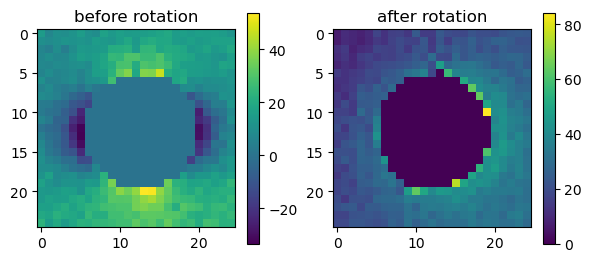

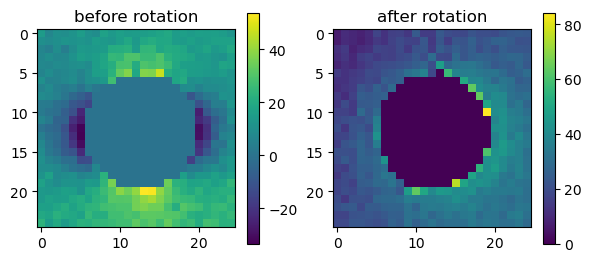

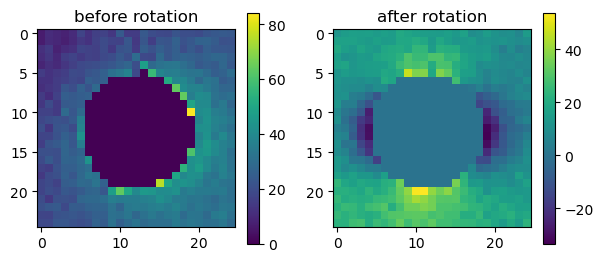

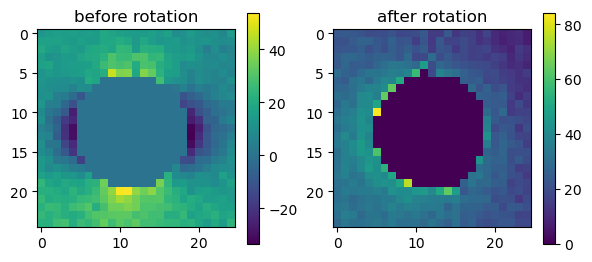

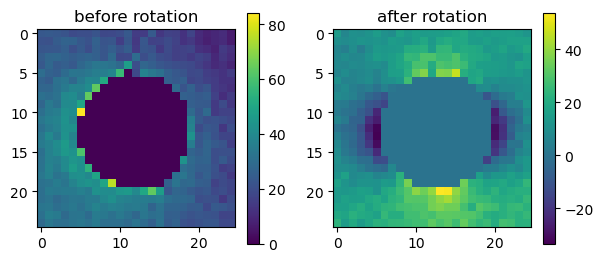

In [27]:
sla_fm_rotated = rotation90clock((rescaled_sla_fm)) #the rotated field map with B0 in the z-direction

#we test the function: after 4 applications, it comes back to what the array was
test=rotation90clock(rotation90clock(rotation90clock(rotation90clock((rescaled_sla_fm)))))

## II. Load the simulation field map and rescale it to the same scale as the experiment

In [29]:
simu = scipy.io.loadmat('sphere_simulation.mat')
sphere_simu = simu['S'] #simulated mask
simu_sla = simu['sus_S'] #simulated FM
print(np.shape(simu_sla))

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.imshow(sphere_simu[100:200,100:200,150])
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow((simu_sla[100:200,100:200,150]).real)
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
# plt.imshow((simu_sla[100:200,150,100:200]).real)
plt.imshow((simu_sla[:,150,:]).real)
plt.colorbar()
plt.tight_layout()


MemoryError: Unable to allocate 206. MiB for an array with shape (27000000,) and data type complex64

In [ ]:
'''
Reshaping the Simulated mask and field map to a 25*25*25 size
'''

#### the rescale functions works only on 2D so need to do it for every slices
simu_sla_rescaled1 = np.zeros((25,25,100))
simu_sla_rescaled = np.zeros((25,25,25))

sphere_rescaled1= np.zeros((25,25,100))
sphere_rescaled = np.zeros((25,25,25))

for slice in range(100):  #resize on xy directions"
    simu_sla_rescaled1[:,:,slice] = resc(simu_sla[100:200,100:200,slice+100].real, 0.25, anti_aliasing=False)
    sphere_rescaled1[:,:,slice] = resc(sphere_simu[100:200,100:200,slice+100], 0.25, anti_aliasing=False)

for j in range(25): #resize the z direction
    simu_sla_rescaled[:,j, :] = downscale_local_mean(simu_sla_rescaled1[:,j,:], (1, 4))
    sphere_rescaled[:,j, :] = downscale_local_mean(sphere_rescaled1[:,j,:], (1, 4))


plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow(simu_sla[100:200,100:200,150].real)
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(simu_sla_rescaled[:,:,12])
# plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.imshow(sphere_rescaled[:,:,12])
# plt.colorbar()
print(np.shape(simu_sla), np.shape(simu_sla_rescaled1), np.shape(simu_sla_rescaled))


#####################"
simu_final = simu_sla_rescaled
mask_simu_final = sphere_rescaled
exp_sla_final = sla_fm_rotated
mask_sla_presque_final = rescaling_og_averaging(mask_sla, x=x_sla,y=y_sla,z=slice_sla, avg_back = 0, slice=12, diameter = 25, plot=False, mask=mask_sla, material = 'SLA')
mask_sla_final = rotation90clock((mask_sla_presque_final))

##############################

## III. Linear regression between experiment and simulation

In [ ]:
def linear_reg_simexp(fm_simu1, fm_exp1, mask_simu1, mask_exp1, part, xmin=0, ymin=0, zmin=0, xmax=np.shape(simu_sla_rescaled)[1], ymax=np.shape(simu_sla_rescaled)[0], zmax=np.shape(simu_sla_rescaled)[2]):
    '''
    Calculate the linear regression between `fm_simu1` and `fm_exp1`, excluding the values inside the masks (inside the ball).
    
    The regression between fm_simu1 and fm_exp1 is calculated on the voxels which coordinates are inside [xmin,xmax],[ymin,ymax],[zmin,zmax]
    Attention: x is the second component and y the first one.
    Plot the linear regression, one slice of the simulated and acquired field map and the histogram of the error. 
    
    Parameters
    ----------
    fm_simu1 : np.ndarray
        3D array of the simulated FM.
    fm_exp1 : np.ndarray
        3D array of the acquired FM.
    mask_simu1 : np.ndarray
        3D array of the simulated mask.
    mask_exp1 : np.ndarray
        3D array of the acquired mask.
    part : str
        description of the material.
    xmin : int, optional
        the minimum x value to use for the regression calculation. The default is 0.
    ymin : int, optional
        the minimum y value to use for the regression calculation. The default is 0.
    zmin : int, optional
        the minimum z value to use for the regression calculation. The default is 0.
    xmax : int, optional
        the maximum x value to use for the regression calculation. The default is np.shape(simu_sla_rescaled)[1].
    ymax : int, optional
        the maximum y value to use for the regression calculation. The default is np.shape(simu_sla_rescaled)[0].
    zmax : int, optional
        the maximum z value to use for the regression calculation. The default is np.shape(simu_sla_rescaled)[2].

    Returns
    -------
    result_corrected : scipy.stats._stats_mstats_common.LinregressResult
        A tuple containing the parameters of the regression line.
    '''
    ### reshaping to 1D vector
    
    fm_simu=fm_simu1[ymin:ymax, xmin:xmax, zmin:zmax]
    fm_exp=fm_exp1[ymin:ymax, xmin:xmax, zmin:zmax]
    mask_simu2=mask_simu1[ymin:ymax, xmin:xmax, zmin:zmax]
    mask_exp2=mask_exp1[ymin:ymax, xmin:xmax, zmin:zmax]

    m,n,p = fm_simu.shape
    simu = fm_simu.reshape(m*n*p) #need to have vector 1D to apply the linear regression
    exp = fm_exp.reshape(n*m*p)

    mask_exp = mask_exp2.reshape(m*n*p)
    mask_simu = mask_simu2.reshape(m*n*p)

    exp_corrected = []
    simu_corrected=[]

    for i in range(m*p*n):
        if mask_exp[i]!=0 and mask_simu[i]!=1:
            simu_corrected.append(simu[i])
            exp_corrected.append(exp[i])

    ### regression lineaire
    result_corrected = scipy.stats.linregress(simu_corrected, exp_corrected)
    print(f'######## regression linéaire - {part} ############')
    print(f' fm_exp = {result_corrected.slope} * fm_simu + {result_corrected.intercept} ')
    print(f'R^2 = {result_corrected.rvalue **2}')
    print(f'p-value = {result_corrected.pvalue }')


    #######################"" plot################################
    plt.figure()
    plt.plot(simu_corrected, exp_corrected, '.', c='pink', label=part)
    plt.xlabel('Simulation')
    plt.ylabel('Experience')
    plt.title(f'Correlation between simulation and experience on {part}')
    plt.plot(simu, result_corrected.intercept + result_corrected.slope*simu, 'black')
    plt.legend()
    plt.show()

    
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(fm_simu[int((ymax-ymin)/2)+1,:, :])
    plt.subplot(1,2,2)
#     plt.imshow(fm_simu[:,:, int((zmax-zmin)/2)])
    plt.imshow(fm_exp[int((ymax-ymin)/2)+1,:, :])

    plt.show()

    
    plt.figure() ## histogram of the error
    approx = np.array([result_corrected.intercept + result_corrected.slope*simu_corrected[i] for i in range(len(simu_corrected))])
    error = exp_corrected - approx #f(xi)-y
#     plt.plot(simu_corrected, error)    
    plt.hist(error, bins=75)
    plt.title('Histogram of the error f(xi)-y')
    plt.show()
    
    print(np.shape(fm_simu))
    return result_corrected

In [ ]:
result_sla = linear_reg_simexp(simu_final, exp_sla_final, mask_simu_final, mask_sla_final, part= 'Standard White Resin' , xmin=2, ymin=(2), zmin=2, xmax=23, ymax=23, zmax=23)

Exportation of the results:

In [ ]:
# fig = plt.figure(constrained_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')
# gs = GridSpec(2, 9, figure=fig)
# ax1 = fig.add_subplot(gs[:, 0:6])
# ax1.plot(simu_corrected, exp_corrected, '.', c='pink')
# ax1.set_xlabel('Simulated field map ($ppm$)')
# ax1.set_ylabel('Acquired field map ($Hz$)')
# ax1.set_title('Correlation between simulated and measured field maps')
# # plt.plot(simu, result.intercept + result.slope*simu, 'y', label='all values')
# ax1.plot(simu, result_final.intercept + result_final.slope*simu, 'black', label='$y = 26.7x + 3.3$ \n $R^2 = 0.04$ \n $p_{value} = 0.0$')
# # plt.text(-0.2,0.1,'y = 26.7x + 3.4')
# # ax1.set_aspect('equal', adjustable='box')
# # ax1.axis('square')
# ax1.legend(frameon=False)

# # ax1.set_xlim(-0.8,0.8)
# # ax1.set_ylim(-60,60)
# ax1.text(x=  -0.780,y=108, s='a)', size=12)


# ax2 = fig.add_subplot(gs[0, 6:9])
# ax2.imshow(fm_simu_final_x100_off[25:55,20:70,slice], vmin=-28, vmax=1, aspect='auto')
# ax2.set_title('Simulated field map')
# ax2.axis('off')
# ax2.text(x=  -0.5,y=-2.1, s='b)', size=12)

# ax3 = fig.add_subplot(gs[1, 6:9])
# ax3.imshow(fm_exp_final[25:55,20:70,slice], vmin=-20, vmax=20, aspect='auto')
# ax3.set_title('Measured field map')
# ax3.axis('off')

# # fig.suptitle("GridSpec")
# #### letters
# # plt.text(x= -150 ,y=-58, s='a)', size=12)
# # plt.text(x= 4 ,y=3, s='b)', size=12)

# # plt.savefig(r"C:\Users\b\OneDrive\Documents\NTNU\Master's thesis\TORONTO\abstract\images\linear_regression.png", transparent=False)
# plt.show()

# print('######## Linear regression res=1mm, on the whole array restricted to the space inside the spinal canal ############')
# print(f' fm_exp = {result_final.slope} * fm_simu + {result_final.intercept} with R^2 = {result_final.rvalue **2}')


Now we need to redo all the previous steps to calculate the susceptibility values of all the materials

In [ ]:
mask_pla_presque = rescaling_og_averaging(mask_pla, diameter=25, slice=15, x=x_pla,y=y_pla,z=slice_pla, material='PLA', avg_back=0, mask=mask_pla)
mask_pla_final = rotation90clock((mask_pla_presque))
exp_pla = rescaling_og_averaging(delta_B_PLA, diameter=25, slice=15, x=x_pla,y=y_pla,z=slice_pla, mask=mask_pla)
exp_pla_final = rotation90clock((exp_pla))*mask_pla_final

mask_crystal_presque = rescaling_og_averaging(mask_crystal, diameter=25, slice=15, x=x_crystal,y=y_crystal,z=slice_crystal, material='3M Crystal', avg_back=0)
mask_crystal_final = rotation90clock((mask_crystal_presque))
exp_crystal = rescaling_og_averaging(delta_B_crystal, diameter=25, slice=15, x=x_crystal,y=y_crystal,z=slice_crystal, mask=mask_crystal)
exp_crystal_final = rotation90clock((exp_crystal)) *mask_crystal_final 

mask_flexible_presque = rescaling_og_averaging(mask_flexible, diameter=25, slice=15, x=x_flexible,y=y_flexible,z=slice_flexible, material='flexible', avg_back=0, mask=mask_flexible)
mask_flexible_final = rotation90clock((mask_flexible_presque))
exp_flexible = rescaling_og_averaging(delta_B_flexible, diameter=25, slice=15, x=x_flexible,y=y_flexible,z=slice_flexible, mask=mask_flexible)
exp_flexible_final = rotation90clock((exp_flexible))*mask_flexible_final 

mask_nylon_presque = rescaling_og_averaging(mask_nylon, diameter=25, slice=15, x=x_nylon,y=y_nylon,z=z_nylon, material='nylon', avg_back=0, mask=mask_nylon)
mask_nylon_final = rotation90clock((mask_nylon_presque))
exp_nylon = rescaling_og_averaging(delta_B_nylon, diameter=25, slice=15, x=x_nylon,y=y_nylon,z=z_nylon, mask=mask_nylon)
exp_nylon_final = rotation90clock((exp_nylon))*mask_nylon_final 


In [ ]:
linear_reg_simexp(fm_simu1=simu_final, fm_exp1 = exp_pla_final, mask_simu1 = mask_simu_final, mask_exp1 = mask_pla_final, part='PLA', xmin=2, ymin=(2), zmin=2, xmax=23, ymax=23, zmax=23)


In [ ]:
linear_reg_simexp(fm_simu1=simu_final, fm_exp1 = exp_crystal_final, mask_simu1 = mask_simu_final, mask_exp1 = mask_crystal_final, part='Crystal', xmin=2, ymin=(2), zmin=2, xmax=23, ymax=23, zmax=23)


In [ ]:
linear_reg_simexp(fm_simu1=simu_final, fm_exp1 = exp_flexible_final, mask_simu1 = mask_simu_final, mask_exp1 = mask_flexible_final, part='Flexible', xmin=2, ymin=(2), zmin=2, xmax=23, ymax=23, zmax=23)


In [ ]:
linear_reg_simexp(fm_simu1=simu_final, fm_exp1 = exp_nylon_final, mask_simu1 = mask_simu_final, mask_exp1 = mask_nylon_final, part='Nylon', xmin=2, ymin=(2), zmin=2, xmax=23, ymax=23, zmax=23)
